## Final Project Submission

Please fill out:
* Student name: Joshua Brancazio
* Student pace: full time
* Scheduled project review date/time: 12.22.18/8am cst
* Instructor name: Rafael Carrasco
* Blog post URL: https://jbrancazio.github.io/exploratory_data_analysis


***
# Finalized Scrubbing Code


I moved my final code for scrubbing data here so that is it easy for me to get started with this project. Notes are in the code and my process of how I got there is detailed below. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np

import statsmodels.api as sm

from statsmodels.formula.api import ols
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score



In [2]:
df=pd.read_csv('kc_house_data.csv')

**Changing types and removing nulls**

In [110]:
#Replace waterfront NaN with category NaN, turn type('Category')
df['waterfront'].replace(np.nan,'NaN',inplace=True)
df['waterfront'] = df['waterfront'].astype('category')

#Turn condition into categories
df['condition'] = df['condition'].astype('category')

df.drop(df.loc[df['bedrooms'] == 33].index,inplace=True)

#turn type('Category')
bins_grade = ['3', '4', '5','6','7', '8','9', '10','11','12','13']
df['grade']= pd.cut(df['grade'],[0,3,4,5,6,7,8,9,10,11,12,13],labels=bins_grade)


df.drop(df.loc[df['sqft_basement'] == '?'].index,inplace=True)
df['sqft_basement'] = df['sqft_basement'].astype('float64')

#create Price/Square foot indicator        
df['price_sqft'] = (df.price/df.sqft_living)

df['yr_renovated'].replace(np.nan,int(0),inplace=True)
bins_reno = ['0','1940', '1950', '1960','1970','1980', '1990', '2000','2010']
df['yr_renovated']= pd.cut(df['yr_renovated'],[0,1940,1950,1960,1970,1980,1990,2000,2010,2020],labels=bins_reno)

**Transformations and Standardizations**

In [111]:
#log transformation for sqft data
for var in [col for col in df.columns if 'sqft' in col]:
    df[var+'_log'] = np.log(df[var])
    
#log transformation for price
df['price_log'] = np.log(df['price'])

for var in ['bedrooms','bathrooms','long','lat','view']:
    df[var+'_z']=(df[var]-np.mean(df[var]))/np.std(df[var])

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


**Creating Dummmies**

I kept this seperate so that I can still explore the categories in df easily. I will add those I am interested into the 

In [112]:
reno=df['yr_renovated'].copy()
reno = pd.get_dummies(reno,prefix='reno')
reno.drop('reno_0',axis=1,inplace=True)

cond=df['condition'].copy()
cond= pd.get_dummies(cond,prefix='cond')
cond.drop('cond_1',axis=1,inplace=True)

grade=df['grade'].copy()
grade = pd.get_dummies(grade,prefix='grade')
grade.drop('grade_3',axis=1,inplace=True)

waterfront=df['waterfront'].copy()
waterfront = pd.get_dummies(waterfront,prefix='wf')
waterfront.drop('wf_NaN',axis=1,inplace=True)

***
# Module 1 Project

I followed the OSEMiN process frame work for this Data Project

## Obtain

The purpose of this project is to predict the selling price of a house by using a muiltivariate linear regression to model the Kings County House Sales dataset. I will start by importing the necessary libraries and dataset. 
**I have moved the scrubbing code to the top of the notebook for easy execution. The code in comments is code I decided to remove**

In [3]:
import pandas as pd
df=pd.read_csv('kc_house_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [4]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

I also want to import some libraries I will likely end up using for visualization and functions.

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np

## Scrub

I want to start the scrubbing process by getting a quick understanding of my dataset. This is easily done through .info(), 5-point statistics, and plotting a histogram.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


#### Null Values

From the information about I can tell that most of my data is in numerical datatype. I have some missing values in waterfront, view, and yr_renovated.

In [7]:
for var in ['waterfront', 'view', 'yr_renovated']:
    unique = df[var].unique()
    count = df[var].value_counts()
    null_values=df[var].isna().sum()
    percentage = null_values/df.shape[0]
    print(var,'analysis')
    print('Unique Values: ',unique)
    print('Value Counts: ',count)
    print('Null Counts: ',null_values)
    print('Percentage Missing: ',round((percentage*100),2))
    print('------------------------''\n')

waterfront analysis
Unique Values:  [nan  0.  1.]
Value Counts:  0.0    19075
1.0      146
Name: waterfront, dtype: int64
Null Counts:  2376
Percentage Missing:  11.0
------------------------

view analysis
Unique Values:  [ 0. nan  3.  4.  2.  1.]
Value Counts:  0.0    19422
2.0      957
3.0      508
1.0      330
4.0      317
Name: view, dtype: int64
Null Counts:  63
Percentage Missing:  0.29
------------------------

yr_renovated analysis
Unique Values:  [   0. 1991.   nan 2002. 2010. 1992. 2013. 1994. 1978. 2005. 2003. 1984.
 1954. 2014. 2011. 1983. 1945. 1990. 1988. 1977. 1981. 1995. 2000. 1999.
 1998. 1970. 1989. 2004. 1986. 2007. 1987. 2006. 1985. 2001. 1980. 1971.
 1979. 1997. 1950. 1969. 1948. 2009. 2015. 1974. 2008. 1968. 2012. 1963.
 1951. 1962. 1953. 1993. 1996. 1955. 1982. 1956. 1940. 1976. 1946. 1975.
 1964. 1973. 1957. 1959. 1960. 1967. 1965. 1934. 1972. 1944. 1958.]
Value Counts:  0.0       17011
2014.0       73
2003.0       31
2013.0       31
2007.0       30
2000.0     

Looking at this data, it seems that there are significant null values in both yr_renovated as well as waterfront. For now, since the percentages of data are so large (11% and 17.9% respectively), I do not want to simply remove them. 

Waterfront only have unique values of 0 and 1 which would indicate that it is categorical data. In this case I would turn the missing data into a category type.

In [8]:
df['waterfront'].replace(np.nan,'NaN',inplace=True)
df['waterfront'] = df['waterfront'].astype('category')

View has less values, only 63 or 0.29%. For this variable I will simply drop the missing rows. 

In [9]:
df.dropna(axis=0,subset=['view'],inplace=True)

For yr_renovated I decided to turn it into a categorical data since the other options (mean replacement) did not seem to make sence. I binned based on decade and turned null values into a NaN category. 

In [10]:
df['yr_renovated'].replace(np.nan,int(0),inplace=True)
bins_reno = ['0','1940', '1950', '1960','1970','1980', '1990', '2000','2010']
df['yr_renovated']= pd.cut(df['yr_renovated'],[0,1940,1950,1960,1970,1980,1990,2000,2010,2020],labels=bins_reno)

#### 5-Point Statistics

I like running my 5-point statistics along side plotting the histograms because it allows me to get a visual idea of the data. 

In [3]:
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.159700e+04,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,19221.000000,21534.000000,21597.000000,21597.000000,21597.000000,21597.000000,17755.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,4.580474e+09,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,0.007596,0.233863,3.409825,7.657915,1788.596842,1970.999676,83.636778,98077.951845,47.560093,-122.213982,1986.620318,12758.283512
std,2.876736e+09,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,0.086825,0.765686,0.650546,1.173200,827.759761,29.375234,399.946414,53.513072,0.138552,0.140724,685.230472,27274.441950
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,370.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


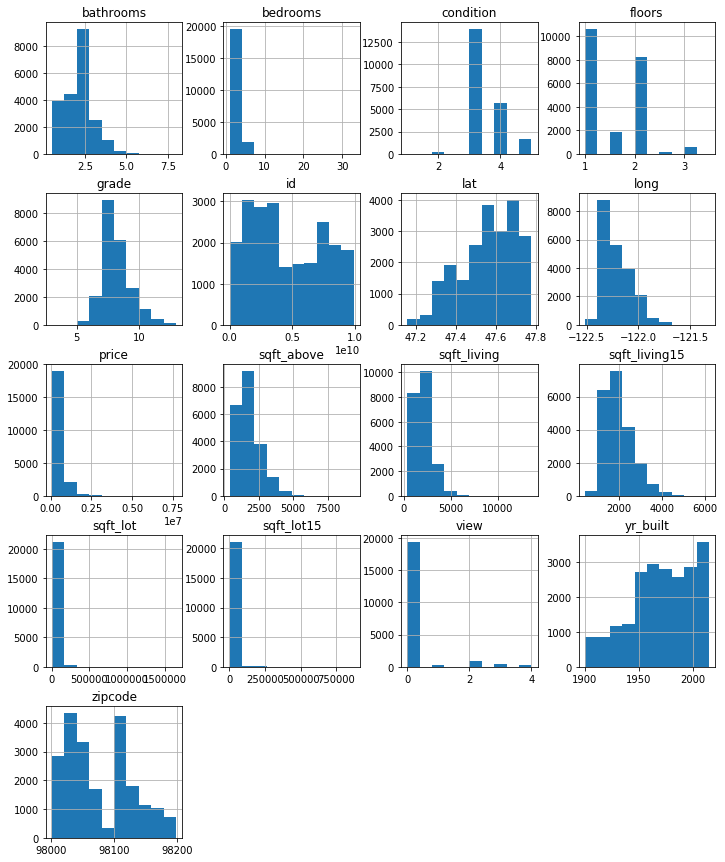

In [12]:
df.hist(figsize=(12,15));

First that jumps out is that conditions, floors should be categorical so we can do that. I also decided to look up the Kings County Glossary to see if I can gather any more information on our [variables](https://www.kingcounty.gov/), which gives some more insite into grade and confirms I should categorize the data. **Upon further thought I realized that floor could be a discrete variable so I decided to keep it as a numerical value.**

In [13]:
df['condition'] = df['condition'].astype('category')

#df['floors'] = df['floors'].astype('category')

bins_grade = ['3', '4', '5','6','7', '8','9', '10','11','12','13']
df['grade']= pd.cut(df['grade'],[0,3,4,5,6,7,8,9,10,11,12,13],labels=bins_grade)

Bedrooms and bathrooms seem to be categorical. This can be confirmed through the histogram. The bedroom histogram also seems to be positively skewed so I decided to categorize Bedrooms and remove the outlier of the house with 33 rooms. **Similar to floors, I decided to keep bedrooms and bathrooms as Numerical Data.**

In [14]:
#bins_bath = ['0_1', '1_2', '2_3','3_4','4_5', '5_6','6_7', '7_8',]
#df['bathrooms']= pd.cut(df['bathrooms'],[0,1,2,3,4,5,6,7,8],labels=bins_bath)


#df.drop(df.loc[df['bedrooms'] == 33].index,inplace=True) 
#df['bedrooms'] = df['bedrooms'].astype('category')

Finally, for this step I want to turn sqft_basement into an integer type. but we have to remove the "?" value for sqft_basement and sqft_above since they are only 2% of the data. Overall, this will bring us to around 3% of data removed. Luckily they overlap so removing them from Basement achieves both goals. We should also turn the type into float64.

In [15]:
df.drop(df.loc[df['sqft_basement'] == '?'].index,inplace=True)
df['sqft_basement'] = df['sqft_basement'].astype('float64')

## Explore

I started by simply graphing our data to see if there was anything that looked interesting for deeper investigation. 

The first set of graphs groups by conditional variables and plots the mean price. 

The second set plots the histogram and KDE.

The third set uses Seaborn jointplot to look at the relationship between numerical data and price in greater detail



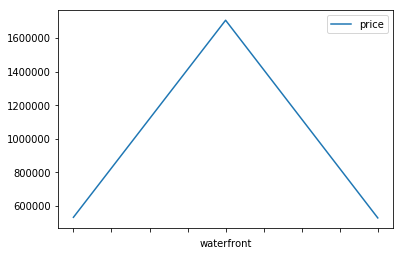

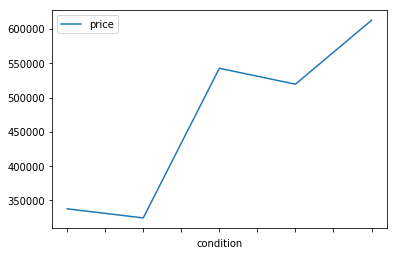

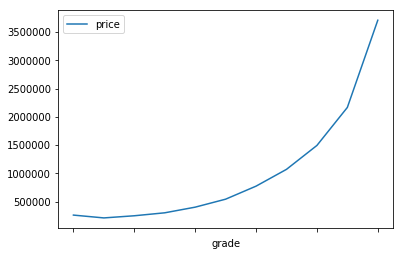

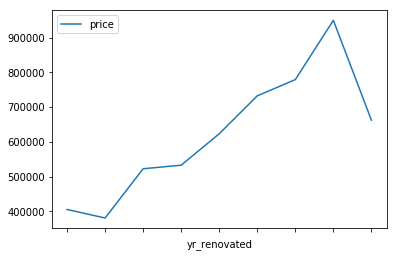

In [16]:
for var in df.select_dtypes(include='category'):
    df.groupby(var)['price'].mean().plot(kind='line')
    plt.legend()
    plt.show()

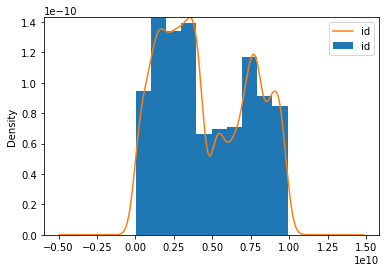

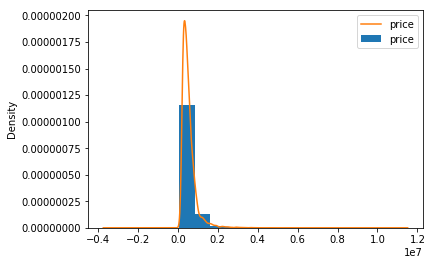

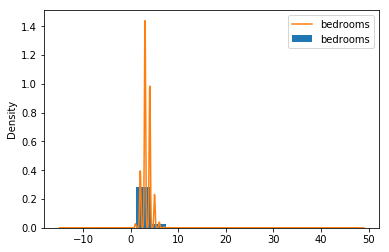

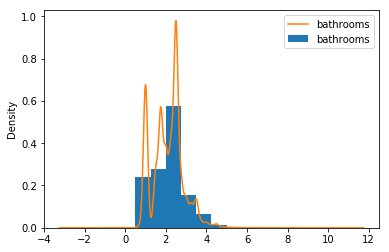

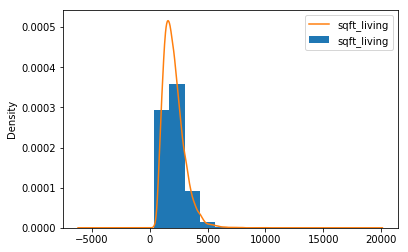

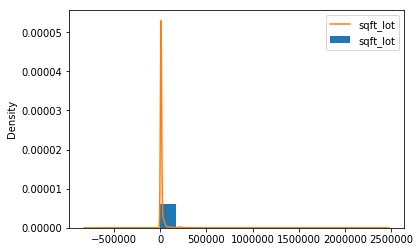

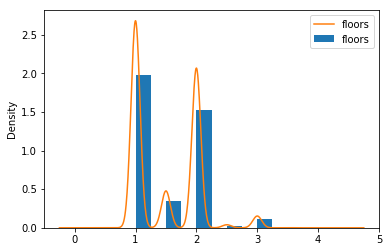

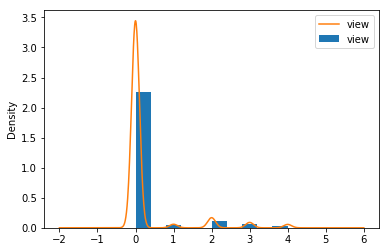

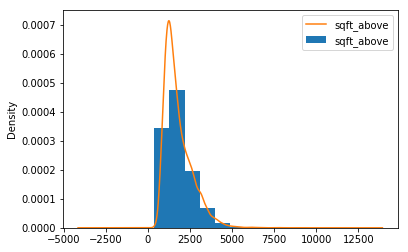

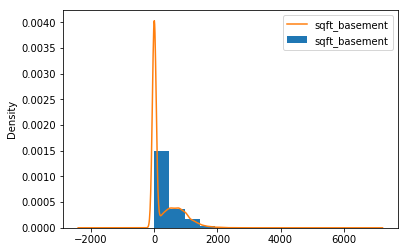

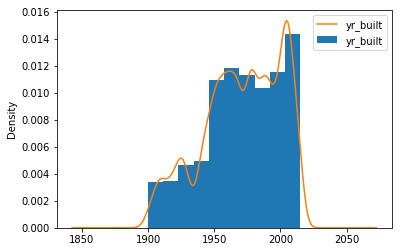

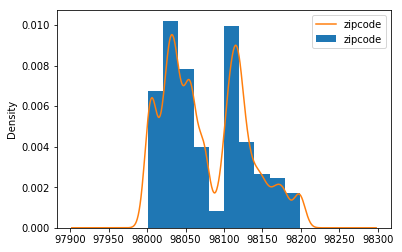

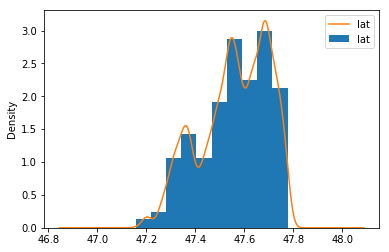

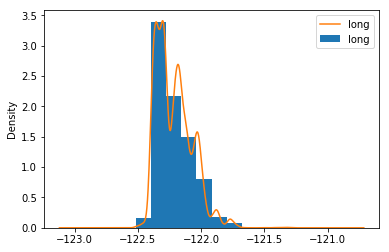

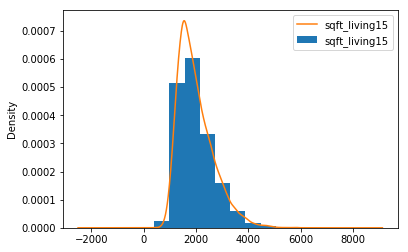

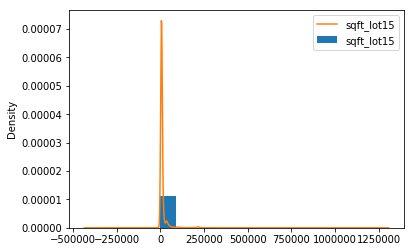

In [17]:
for var in df.select_dtypes(include=['int64','float64']):
    df[var].plot.hist(density=True,label=var)
    df[var].plot.kde(label=var)
    plt.legend()
    plt.show()

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


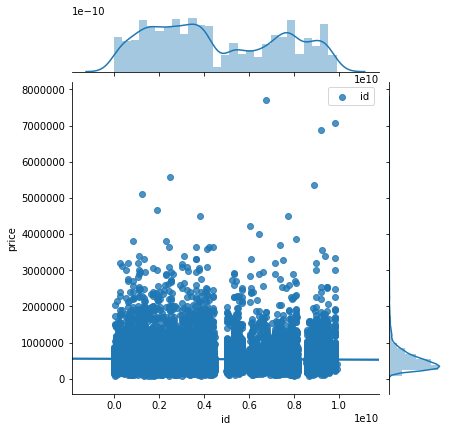

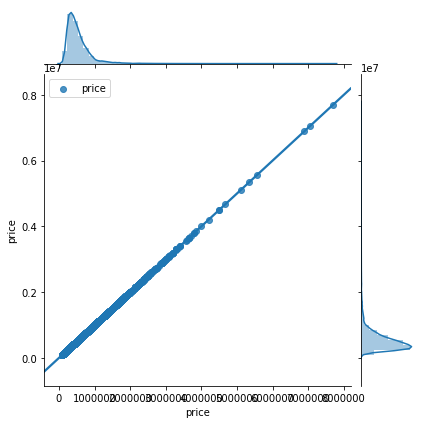

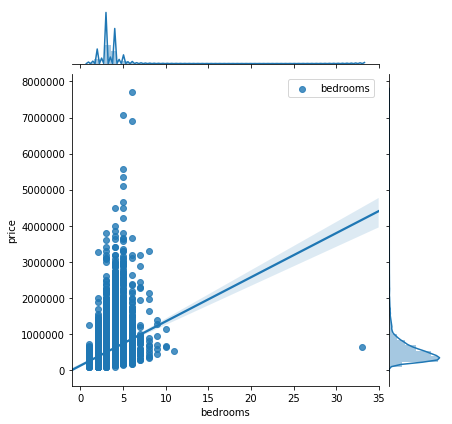

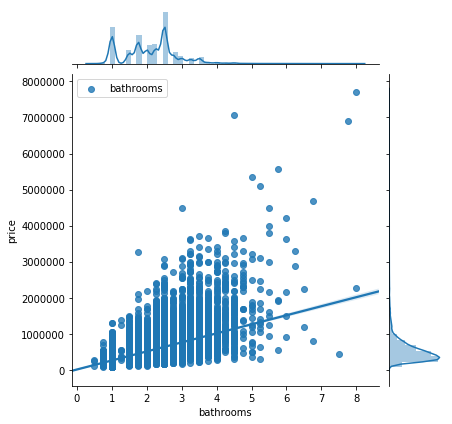

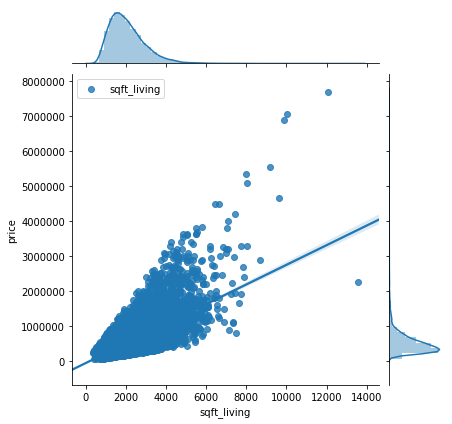

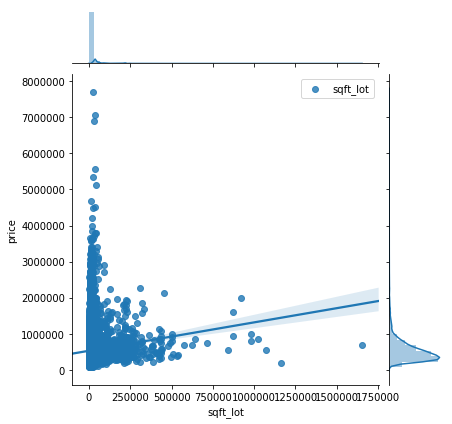

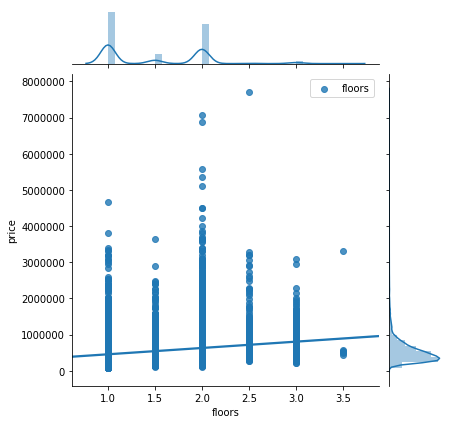

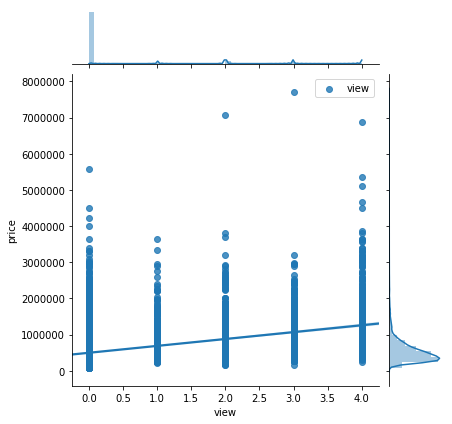

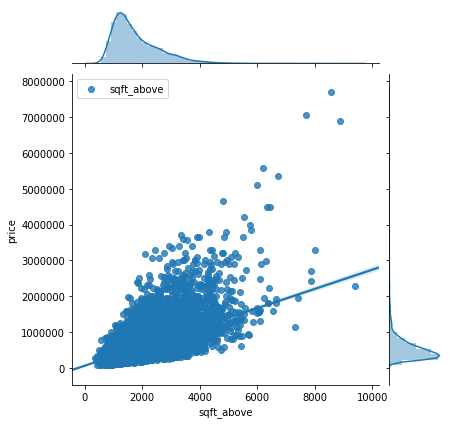

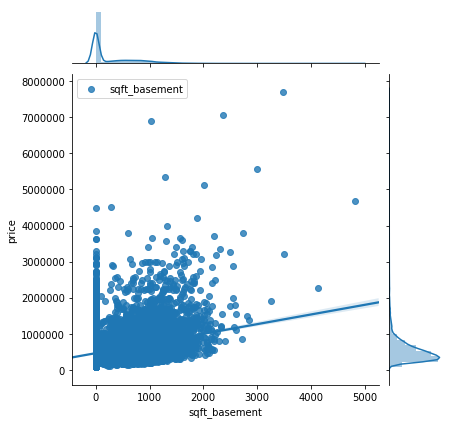

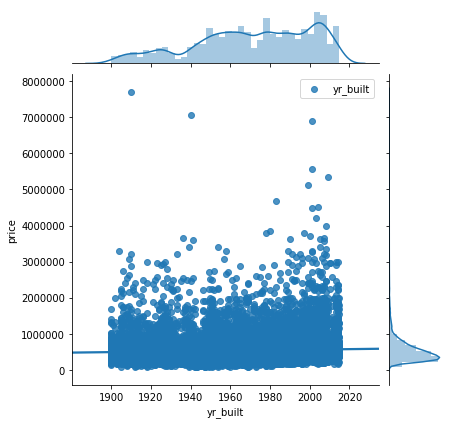

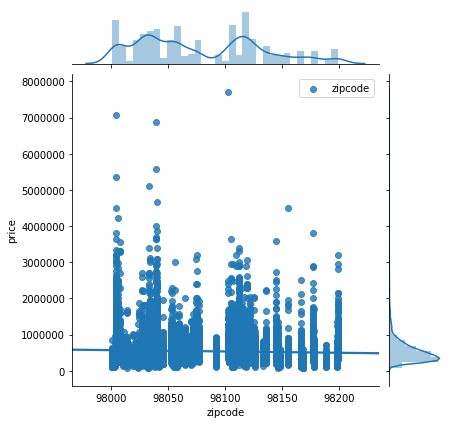

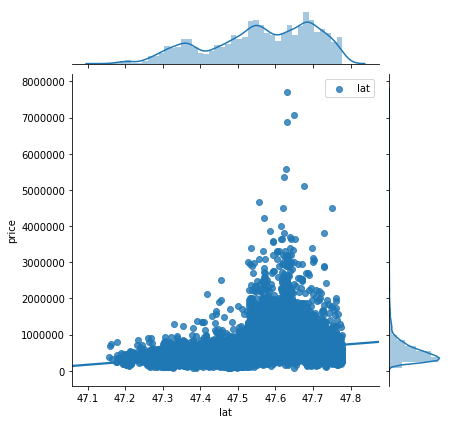

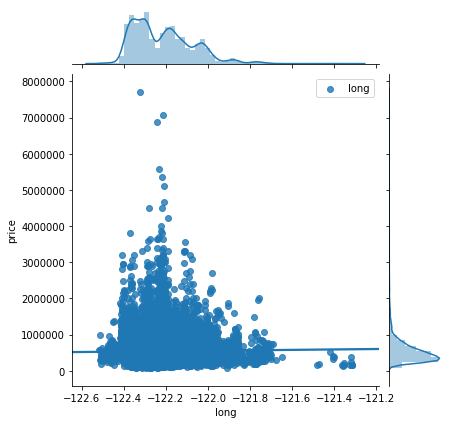

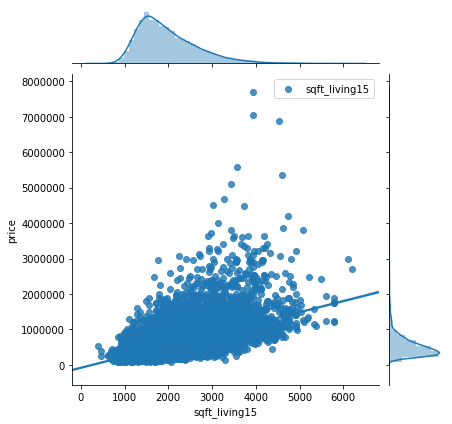

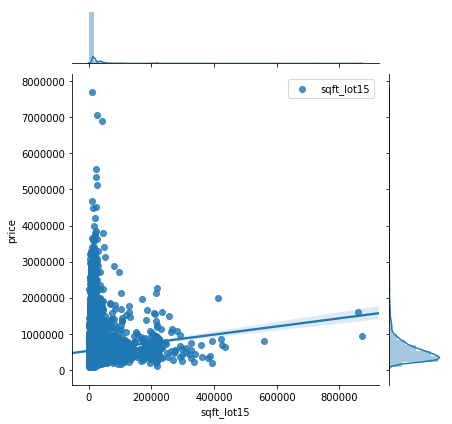

In [18]:
for var in df.select_dtypes(include=['int64','float64']):
    sns.jointplot(x=var , y='price', data=df, kind='reg',label=var)
    plt.legend()
    plt.show()

Based on these graphs it seems that there are some quite a few variable that show relationships with price. 

That being said, many of these distributions seems to be skewed so I will perform a log transformation on the data and check the outcome. **Based on the outcome it seems to have helped with price and sqft but did not do much for the other data. I will use mean-normalization on those variables.**

In [24]:
for var in [col for col in df.columns if 'sqft' in col]:
    df[var+'_log'] = np.log(df[var])
    

df['price_log'] = np.log(df['price'])


for var in ['bedrooms','bathrooms','long','lat','view']:
    df[var+'_z']=(df[var]-np.mean(df[var]))/np.std(df[var])

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


**Finally we will create our dummies**

In [96]:
reno=df['yr_renovated'].copy()
reno = pd.get_dummies(reno,prefix='reno')
reno.drop('reno_0',axis=1,inplace=True)

cond=df['condition'].copy()
cond= pd.get_dummies(cond,prefix='cond')
cond.drop('cond_1',axis=1,inplace=True)

grade=df['grade'].copy()
grade = pd.get_dummies(grade,prefix='grade')
grade.drop('grade_11',axis=1,inplace=True)

waterfront=df['waterfront'].copy()
waterfront = pd.get_dummies(waterfront,prefix='wf')
waterfront.drop('wf_NaN',axis=1,inplace=True)

**Price per Square Foot**

I was interested in looking a little further into the data to see if I can better understand the relationship between the variables. I created the price per square foot living category and completed the same graphs above for those variable. 

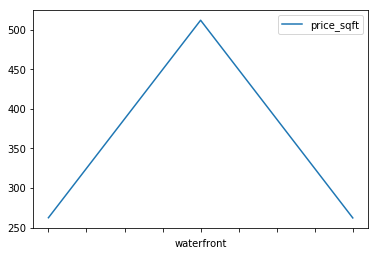

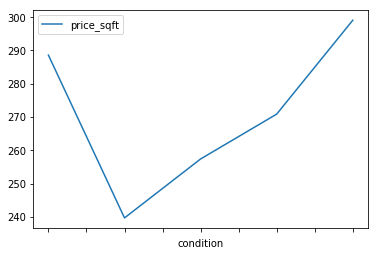

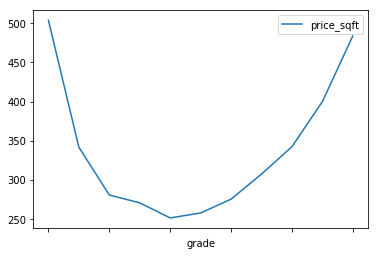

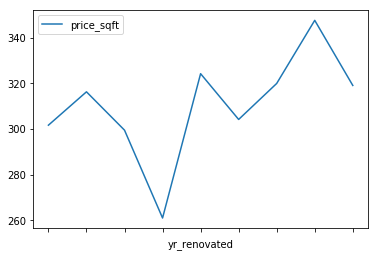

In [20]:
df['price_sqft'] = (df.price/df.sqft_living)

for var in df.select_dtypes(include='category'):
    df.groupby(var)['price_sqft'].mean().plot(kind='line')
    plt.legend()
    plt.show()

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


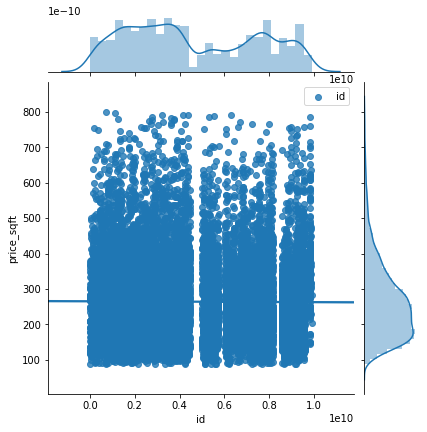

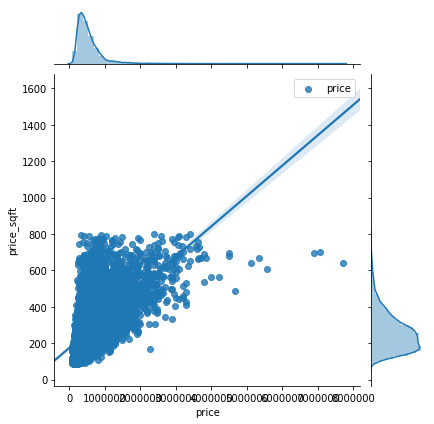

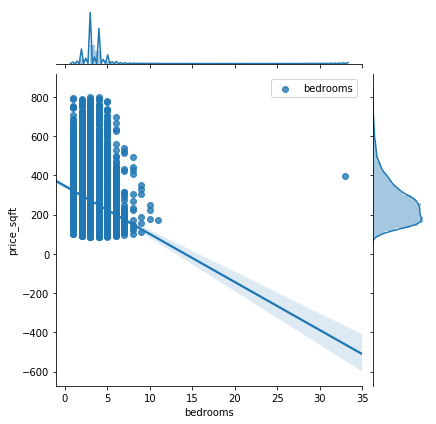

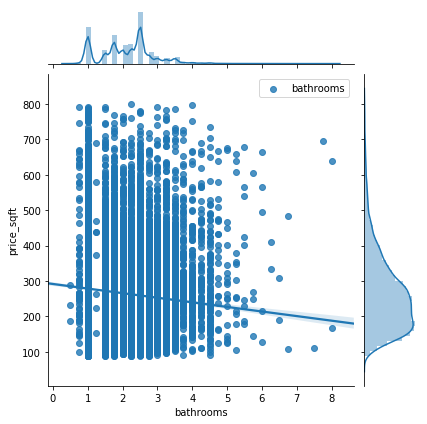

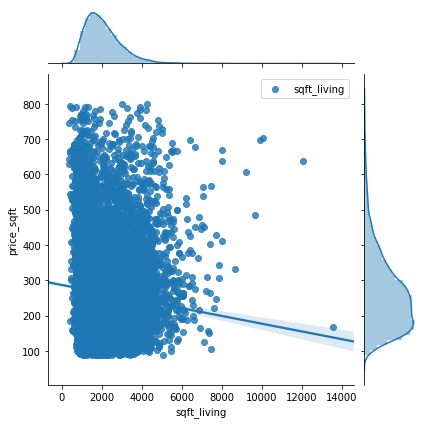

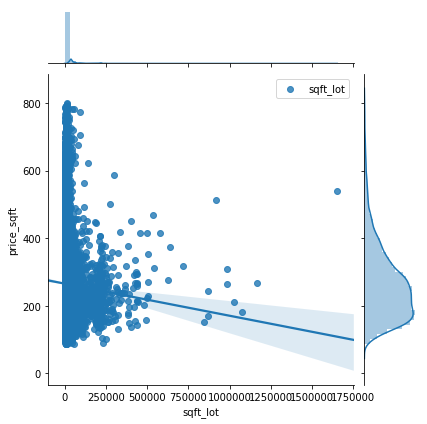

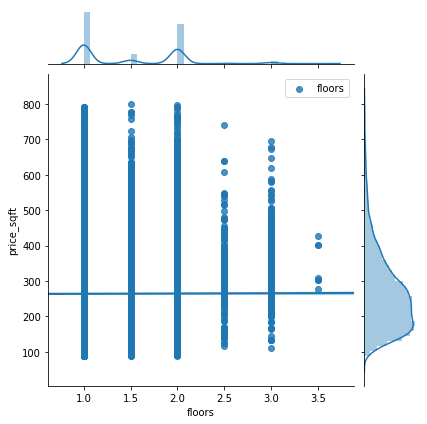

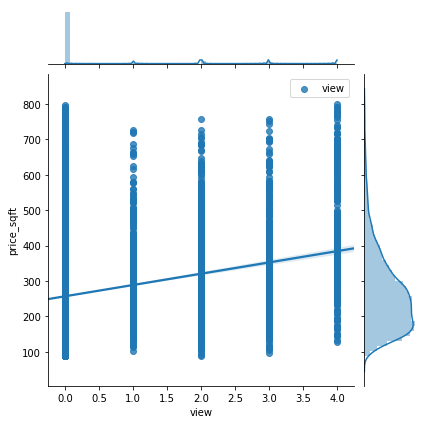

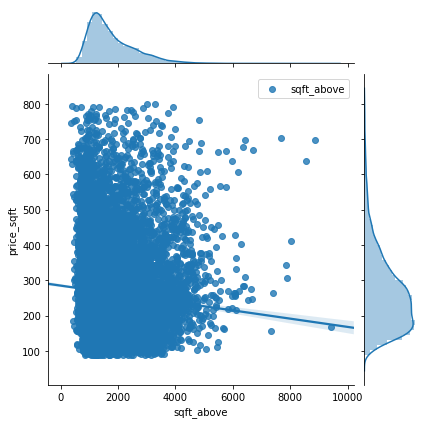

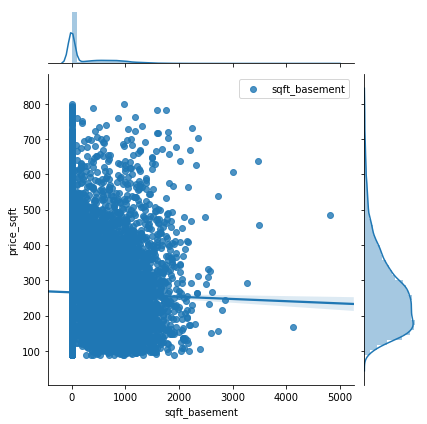

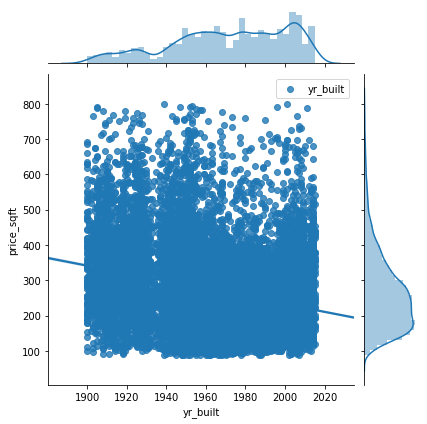

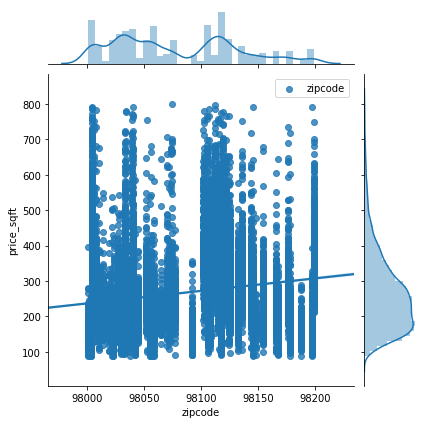

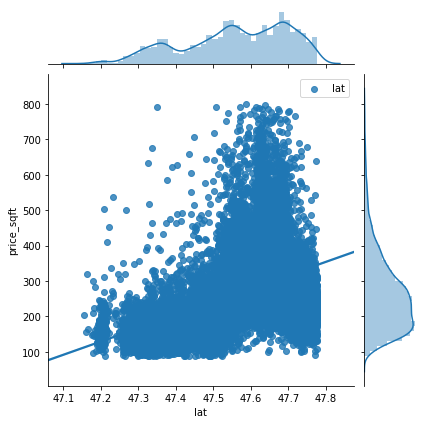

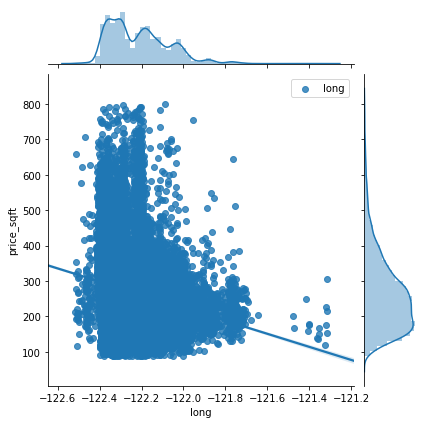

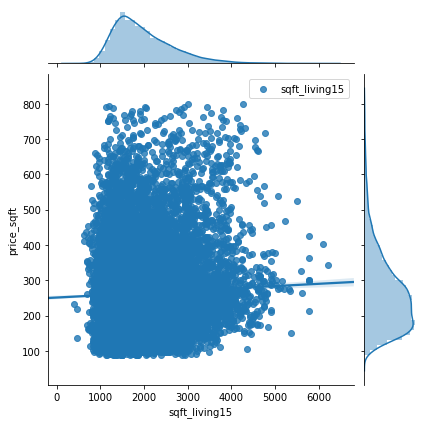

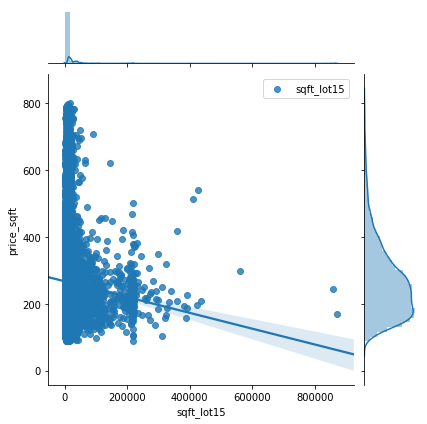

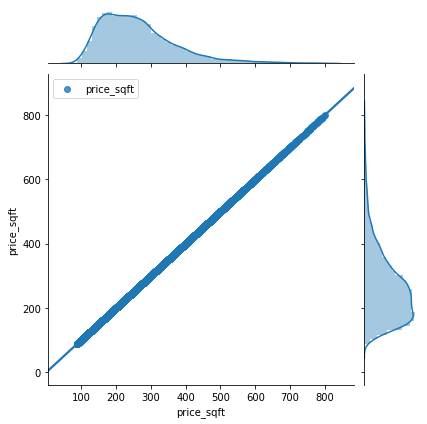

In [21]:
for var in df.select_dtypes(include=['int64','float64']):
    sns.jointplot(x=var , y='price_sqft', data=df, kind='reg',label=var)
    plt.legend()
    plt.show()

Based on the graph above, there seems to be a negative relationship with price per square foot and number of bedrooms and bathrooms. There also seems to be an interesting relationship with Grade.

In [25]:
X=df.bathrooms_z
y=df.price_sqft_log

pred = sm.add_constant(X)
model = sm.OLS(y,pred).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         price_sqft_log   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     147.9
Date:                Sat, 22 Dec 2018   Prob (F-statistic):           6.40e-34
Time:                        00:50:34   Log-Likelihood:                -10243.
No. Observations:               21082   AIC:                         2.049e+04
Df Residuals:                   21080   BIC:                         2.050e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           5.4974      0.003   2029.233      0.000       5.492       5.503
bathrooms_z    -0.0329      0.003    -12.162      0.000      -0.038      -0.028
==============================================================================
Omnibus:                      144.692   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              123.832
Skew:                           0.131   Prob(JB):                     1.29e-27
Kurtosis:                       2.732   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [26]:
X=df.bedrooms_z
y=df.price_sqft_log

pred = sm.add_constant(X)
model = sm.OLS(y,pred).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         price_sqft_log   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     976.1
Date:                Sat, 22 Dec 2018   Prob (F-statistic):          1.66e-209
Time:                        00:50:37   Log-Likelihood:                -9839.1
No. Observations:               21082   AIC:                         1.968e+04
Df Residuals:                   21080   BIC:                         1.970e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.4974      0.003   2068.437      0.000       5.492       5.503
bedrooms_z    -0.0830      0.003    -31.243      0.000      -0.088      -0.078
==============================================================================
Omnibus:                       94.380   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               95.587
Skew:                           0.164   Prob(JB):                     1.75e-21
Kurtosis:                       2.971   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Unfortunately, our analysis shows that number of bedrooms and bathrooms only account for a very small amount of data.

### Check for Multicollinearity


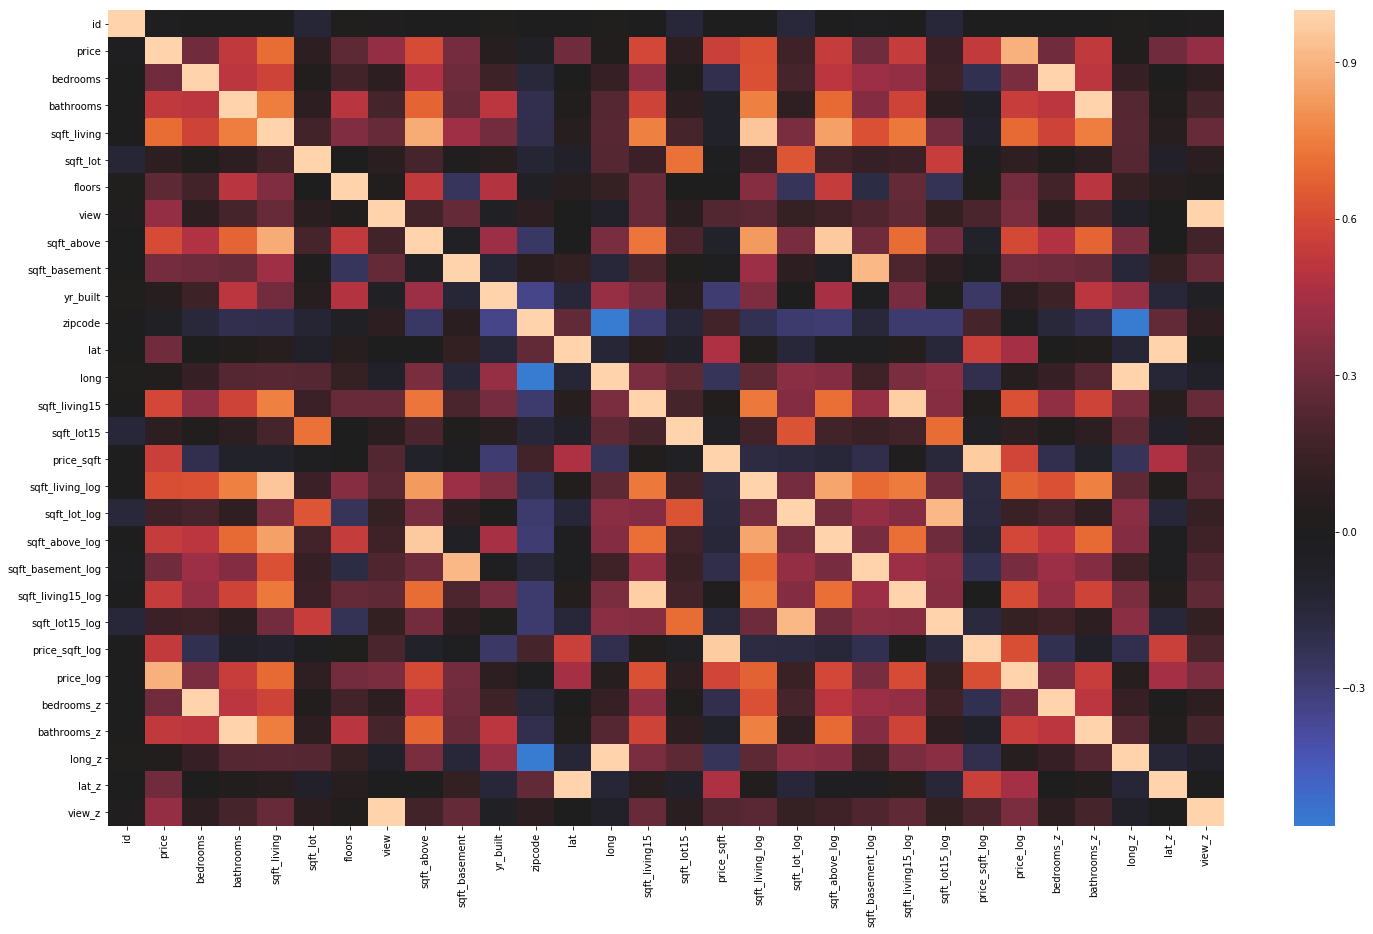

In [30]:
f, ax = plt.subplots(figsize=(25,15))  
sns.heatmap(df.corr(), center=0, )

Based on the data above as well as the multicollinearity I will start my model with the variables. We need to be careful as the sqft shows signs of multicollinearity. For this reason I am only including one variable.

- grade
- sqft_living
- lat
- long
- bedrooms

*I was originally going to use bathrooms in the model but it shows a correlation with sqft_living.*

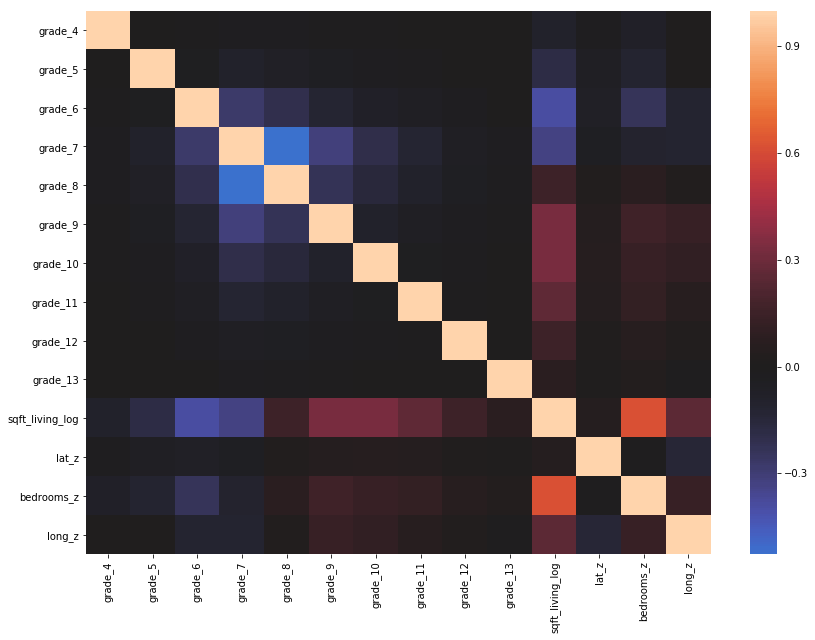

In [39]:
df_final=pd.concat([grade,df.sqft_living_log,df.lat_z,df.bedrooms_z,df.long_z],axis=1)
f, ax = plt.subplots(figsize=(14,10))  
sns.heatmap(df_final.corr(), center=0, )

## MODELING

I started of with the model from above. Bolow is the regression results.

In [40]:
X=df_final
y=df.price_log

pred = sm.add_constant(X)
model = sm.OLS(y,pred).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.709
Model:                            OLS   Adj. R-squared:                  0.708
Method:                 Least Squares   F-statistic:                     3658.
Date:                Sat, 22 Dec 2018   Prob (F-statistic):               0.00
Time:                        00:56:04   Log-Likelihood:                -3390.8
No. Observations:               21082   AIC:                             6812.
Df Residuals:                   21067   BIC:                             6931.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               9.6282      0.290     33.207      0.000       9.060      10.197
grade_4            -0.8925      0.290     -3.082      0.002      -1.460      -0.325
grade_5            -0.9122      0.285     -3.201      0.001      -1.471      -0.354
grade_6            -0.8675      0.284     -3.049      0.002      -1.425      -0.310
grade_7            -0.7762      0.285     -2.728      0.006      -1.334      -0.219
grade_8            -0.6237      0.285     -2.192      0.028      -1.182      -0.066
grade_9            -0.4215      0.285     -1.481      0.139      -0.980       0.136
grade_10           -0.2329      0.285     -0.818      0.414      -0.791       0.325
grade_11           -0.0338      0.285     -0.118      0.906      -0.593       0.525
grade_12            0.2366      0.286      0.826      0.409      -0.325       0.798
grade_13            0.5160      0.296      1.745      0.081      -0.064       1.096
sqft_living_log     0.5395      0.009     63.323      0.000       0.523       0.556
lat_z               0.2008      0.002    100.374      0.000       0.197       0.205
bedrooms_z         -0.0194      0.003     -7.572      0.000      -0.024      -0.014
long_z             -0.0419      0.002    -20.354      0.000      -0.046      -0.038
==============================================================================
Omnibus:                      560.184   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              766.834
Skew:                           0.305   Prob(JB):                    3.05e-167
Kurtosis:                       3.708   Cond. No.                     3.69e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.69e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Based on this model we can explain 71% of the prices if we take into condiseraton: 
 - The location of the house
 - number of bedrooms
 - number of bathrooms
 - size
 - Kings County Grading Category

This is a faily high number but I would like to see if we can do better. 

In order to tak another apporoach I am going to use stepwise selection. 

In [41]:
import statsmodels.api as sm

def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [142]:
df_test=pd.concat([df.bedrooms_z,df.bathrooms_z,df.sqft_living_log,
                   df.floors,waterfront,df.long_z,df.lat_z,grade,cond],axis=1)

result = stepwise_selection(df_test, df["price"], verbose = True)
print('resulting features:')
print(result)

Add  grade_12                       with p-value 0.0
Add  sqft_living_log                with p-value 0.0
Add  wf_1.0                         with p-value 0.0
Add  lat_z                          with p-value 0.0
Add  grade_11                       with p-value 0.0
Add  grade_10                       with p-value 0.0
Add  grade_13                       with p-value 0.0
Add  grade_9                        with p-value 1.14797e-231
Add  long_z                         with p-value 2.97069e-116
Add  cond_3                         with p-value 4.98686e-97
Add  grade_8                        with p-value 2.88141e-80
Add  bathrooms_z                    with p-value 9.39503e-32
Add  cond_5                         with p-value 9.23575e-26
Add  floors                         with p-value 3.29564e-06
Add  bedrooms_z                     with p-value 3.2097e-06
Add  cond_4                         with p-value 0.00390066
Drop cond_3                         with p-value 0.209791


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.


Add  grade_4                        with p-value 0.00502291
resulting features:
['grade_12', 'sqft_living_log', 'wf_1.0', 'lat_z', 'grade_11', 'grade_10', 'grade_13', 'grade_9', 'long_z', 'grade_8', 'bathrooms_z', 'cond_5', 'floors', 'bedrooms_z', 'cond_4', 'grade_4']


Based on the stepwise projection above I have decided to add condition, as well as Waterfront to my model.

In [145]:
df_final2=pd.concat([waterfront,grade,df.sqft_living_log,df.lat_z,df.bedrooms_z,df.long_z],axis=1)
df_final.head()

,grade_4,grade_5,grade_6,grade_7,grade_8,grade_9,grade_10,grade_11,grade_12,grade_13,sqft_living_log,lat_z,bedrooms_z,long_z
0,0,0,0,1,0,0,0,0,0,0,7.073270,-0.354857,-0.402609,-0.306941
1,0,0,0,1,0,0,0,0,0,0,7.851661,1.159235,-0.402609,-0.747897
2,0,0,1,0,0,0,0,0,0,0,6.646391,1.281200,-1.483721,-0.136248
3,0,0,0,1,0,0,0,0,0,0,7.580700,-0.285576,0.678502,-1.274200
4,0,0,0,0,1,0,0,0,0,0,7.426549,0.407241,-0.402609,1.200846


In [146]:
X=df_final2
y=df.price_log

pred = sm.add_constant(X)
model = sm.OLS(y,pred).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.720
Model:                            OLS   Adj. R-squared:                  0.719
Method:                 Least Squares   F-statistic:                     3388.
Date:                Sat, 22 Dec 2018   Prob (F-statistic):               0.00
Time:                        02:42:50   Log-Likelihood:                -3002.8
No. Observations:               21142   AIC:                             6040.
Df Residuals:                   21125   BIC:                             6175.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               9.7028      0.285     34.063      0.000       9.144      10.261
wf_0.0              0.0006      0.006      0.106      0.916      -0.011       0.013
wf_1.0              0.6736      0.024     27.599      0.000       0.626       0.721
grade_4            -0.8896      0.284     -3.130      0.002      -1.447      -0.333
grade_5            -0.9173      0.280     -3.280      0.001      -1.465      -0.369
grade_6            -0.8613      0.279     -3.085      0.002      -1.409      -0.314
grade_7            -0.7662      0.279     -2.744      0.006      -1.313      -0.219
grade_8            -0.6139      0.279     -2.198      0.028      -1.161      -0.066
grade_9            -0.4122      0.279     -1.476      0.140      -0.960       0.135
grade_10           -0.2330      0.280     -0.834      0.405      -0.781       0.315
grade_11           -0.0475      0.280     -0.170      0.865      -0.596       0.501
grade_12            0.1912      0.281      0.680      0.496      -0.360       0.742
grade_13            0.5416      0.290      1.866      0.062      -0.027       1.111
sqft_living_log     0.5278      0.008     62.170      0.000       0.511       0.544
lat_z               0.2023      0.002    103.158      0.000       0.198       0.206
bedrooms_z         -0.0171      0.003     -6.697      0.000      -0.022      -0.012
long_z             -0.0382      0.002    -18.870      0.000      -0.042      -0.034
==============================================================================
Omnibus:                      367.921   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              489.680
Skew:                           0.231   Prob(JB):                    4.65e-107
Kurtosis:                       3.586   Cond. No.                     3.72e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.72e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

This model is a little more predictive!

In [47]:
X_train,X_test,y_train,y_test=train_test_split(X,y, test_size=0.3)
linreg=LinearRegression()
linreg.fit(X_train,y_train)
y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)
train=mean_squared_error(y_train, y_hat_train)
test=mean_squared_error(y_test, y_hat_test)

print(train)
print(test)

0.07714631548449229
0.07950362669541339


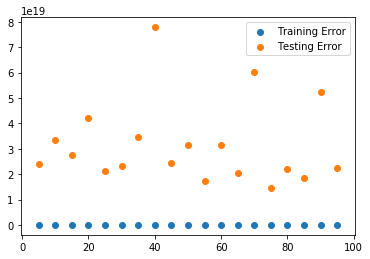

In [48]:
train_error = []
test_error = []
t_sizes = list(range(5,100,5))
for t_size in t_sizes:
    train_error2 = []
    test_error2 = []
    for i in range(100):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
        linreg.fit(X_train, y_train)
        y_hat_train = linreg.predict(X_train)
        y_hat_test = linreg.predict(X_test)
        train_error2.append(mean_squared_error(y_train, y_hat_train))
        test_error2.append(mean_squared_error(y_test, y_hat_test))
    train_error.append(np.mean(train_error2))
    test_error.append(np.mean(test_error2))
plt.scatter(t_sizes, train_error, label='Training Error')
plt.scatter(t_sizes, test_error, label='Testing Error')
plt.legend()
plt.show()

### Interpret

The second model I created has an r-squared value of 0.719. This means that 71.9% of our data can be predicted by our model. While this seems like a high number, if we run multiple predictions, It shows that our model is still a little off. 

Three examples of significant predictors for this data set are sqft_living, waterfront (specifically, if it is on the water front) and latitude/longitude. 

Sqft_living has a positive coef which means that as sqft_living increases so does the selling price. This is also the case with waterfront. If the house is on the waterfront, that will significantly increase the final selling price. 

Latitude and Longitude are interesting variables because they give us an idea of space a well. Long has a slight negative coef, and Lat a slight positive. This means that as we travel north east through the region, the houses will become more expensive. 


For further investigation I would like to: 
- see if I can improve the linearity of the Grade data as this seems to be a great predictor of price
- increase the data from the waterfront category since this is highly predictive(even with only 146 waterfront properties and 2376 missing data points
- I would like to explore a way for a more meaningful longitude/latitude analysis. Since I took the Z-score, the data reflects standard deviations from the mean (Mercer Island). This does really a great predictor. I would be interested in seeing if the price of housing varied in a linear fashion based on the distance from major sporting arena's or Amazon/Starbucks headquarters for example.

***
### Graphs for Presentation

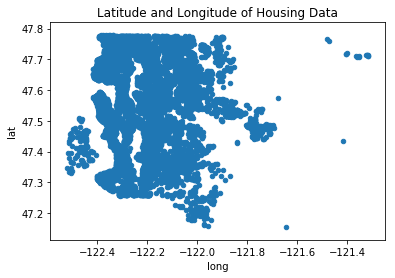

In [150]:
df.plot('long','lat',kind="scatter",title='Latitude and Longitude of Housing Data')
                  

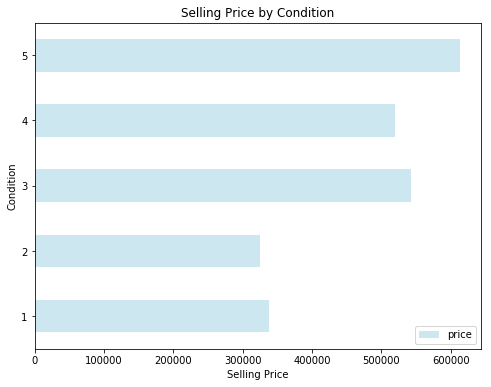

In [165]:
fig,axes=plt.subplots(figsize=(8,6))
df.groupby('condition')['price'].mean().plot(color='#ADD8E6',
                                            kind='barh',alpha=0.6,
                                            title='Selling Price by Condition')
plt.xlabel('Selling Price')
plt.ylabel('Condition')
plt.legend()
plt.show()

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


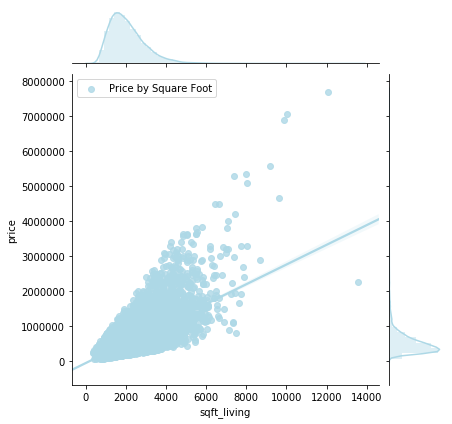

In [196]:
sns.jointplot(x='sqft_living', y='price', data=df, kind='reg',color = '#ADD8E6',label='Price by Square Foot')
plt.legend()
plt.show()


/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


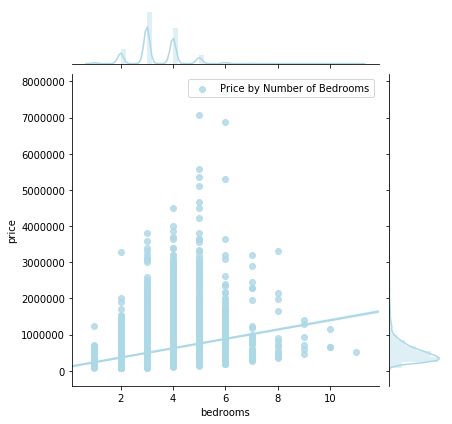

In [198]:
sns.jointplot(x='bedrooms', y='price', data=df, kind='reg',color = '#ADD8E6',label='Price by Number of Bedrooms')
plt.legend()
plt.show()

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


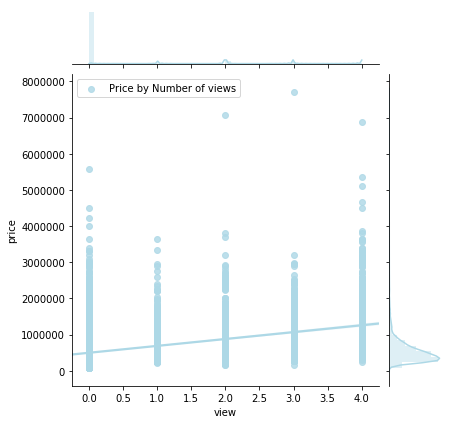

In [201]:
sns.jointplot(x='view', y='price', data=df, kind='reg',color = '#ADD8E6',label='Price by Number of views')
plt.legend()
plt.show()

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


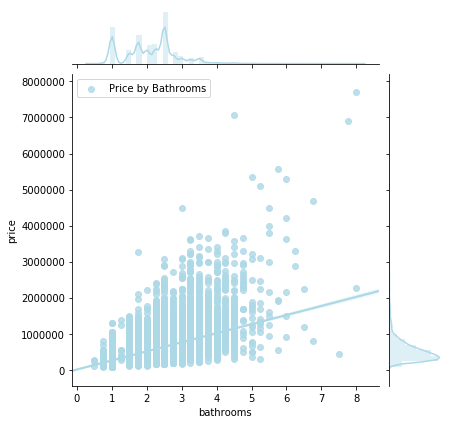

In [202]:
sns.jointplot(x='bathrooms', y='price', data=df, kind='reg',color = '#ADD8E6',label='Price by Bathrooms')
plt.legend()
plt.show()